<a href="https://colab.research.google.com/github/SAR2652/Real_or_Not-_NLP_with_Disaster_Tweets/blob/master/Real_or_Not%3F_NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun  4 14:48:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip3 install kaggle tensorflow-gpu

     |████████████████████████████████| 516.2MB 34kB/s 


In [0]:
!mkdir ~/.kaggle

In [5]:
!ls -a

.  ..  .config	drive  sample_data


In [6]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [0]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [8]:
%cd /content

/content


In [9]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 36.2MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 58.1MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 61.8MB/s]


In [10]:
!ls -a

.  ..  .config	drive  sample_data  sample_submission.csv  test.csv  train.csv


# Real or Not? NLP with Disaster Tweets

## ---- DEFINE ----

To analyze text data in the form of various tweets regarding natural disasters and predict whether the tweet is genuine with regards to the natural disaster or not.

## ---- DISCOVER ----

In [86]:
# import the necessary libraries
import re, pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
import nltk, string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, \
Embedding, LSTM, Input, SpatialDropout1D, Masking, BatchNormalization, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# load and examine the training data
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [13]:
# load and examine the testing data
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
# drop 'id' column from training data
df.drop(['id'], axis = 1, inplace = True)

### Exploratory Data Analysis (EDA)

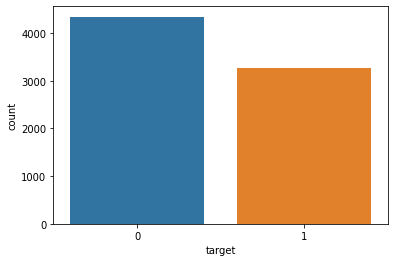

In [15]:
sns.countplot(df['target'])

In [0]:
# convert column 
tweets_text = df['text'].values.tolist()

**Perform Basic Text Preprocessing** 

In [0]:
# create a set of stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(tweets):

    # create an empty list to store preprocessed tweets
    tweet_corpus = []

    # create word corpus to check frequency distribution for words
    word_corpus = []

    # create word corpus to check frequency distribution for lemmatized words
    lemmatized_word_corpus = []

    for tweet in tweets:
        
        # remove non-word characters
        preprocessed_tweet = re.sub(r'\W', ' ', tweet)

        # eliminate single alphabetic characters
        preprocessed_tweet = re.sub(r'\s+[a-z]\s+', ' ', preprocessed_tweet)

        # convert all words to lowercase
        preprocessed_tweet = preprocessed_tweet.lower()

        # eliminate punctuation
        preprocessed_tweet = re.sub(r'^[a-z]\s+', ' ', preprocessed_tweet)

        # eliminate 1 or more spaces
        preprocessed_tweet = re.sub(r'\s+', ' ', preprocessed_tweet)

        # remove stopwords
        words = word_tokenize(preprocessed_tweet)
        tokens = [word for word in words if word not in stop_words]
        filtered_tweet = ' '.join(tokens)

        # Perform lemmatization upon each token
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_filtered_tweet = ' '.join(lemmatized_tokens)

        # add tokens to word corpus to generate frequency distribution
        word_corpus.append(tokens)

        # add lemmatized tokens to lemmatized word corpus to generate frequency distribution
        lemmatized_word_corpus.append(lemmatized_tokens)

        tweet_corpus.append(lemmatized_filtered_tweet)
        # tweet_corpus.append(filtered_tweet)
    
    return tweet_corpus, lemmatized_word_corpus

train_tweet_corpus, lemmatized_word_corpus = preprocess_text(tweets_text)

In [18]:
train_tweet_corpus[:5]

['deed reason earthquake may allah forgive u',
 'forest fire near la ronge sask canada',
 'resident asked shelter place notified officer evacuation shelter place order expected',
 '13 000 people receive wildfire evacuation order california',
 'got sent photo ruby alaska smoke wildfire pours school']

In [19]:
# flatten word corpus from 2D to 1D
word_dist = sum(lemmatized_word_corpus, [])

# Obtain 25 most frequent words in the corpus
frequency_dist = nltk.FreqDist(word_dist)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:25]

['co',
 'http',
 'fire',
 'like',
 'û_',
 'amp',
 'get',
 'new',
 'via',
 '2',
 'one',
 'people',
 'news',
 'u',
 'year',
 'video',
 'time',
 'disaster',
 'emergency',
 'body',
 'day',
 'police',
 'home',
 'building',
 'would']

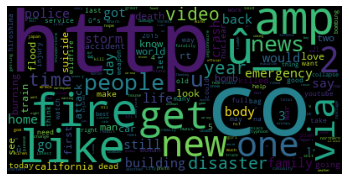

In [20]:
# generate Word Cloud
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### N-Gram Analyses (All tweets)

In [0]:
def generate_ngram_df(n, docs):
    ngstr = ''
    if n == 1:
        ngstr = 'Unigrams' 
    elif n == 2:
        ngstr = 'Bigrams'
    elif n == 3:
        ngstr = 'Trigrams'
    else:
        ngstr == 'N-grams'
    ngrams = dict()
    for doc in docs:
        
        # remove single hyphens 
        # clean_doc = re.sub(r'[-]', ' ', doc)
        
        # eliminate trailing whitespaces
        clean_doc = re.sub(r'\s+', ' ', doc)

        words = clean_doc.split(' ')
        tokens = [word for word in words if word not in stop_words]
        for i in range(len(tokens) - n):
            gram = ' '.join(tokens[i:i + n])
            if gram not in ngrams.keys():
                ngrams[gram] = 1
            else:
                ngrams[gram] += 1
    ngram_df = pd.DataFrame(list(ngrams.items()), columns = [ngstr, 'count'])
    return ngram_df

**Bigram Analysis**

In [22]:
n = 2
bigram_df = generate_ngram_df(n, tweets_text)
bigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
bigram_df.head(10)

,Bigrams,count
0,- Full,66
1,I liked,42
2,liked @YouTube,41
3,@YouTube video,41
4,burning buildings,40
5,suicide bomber,37
6,Northern California,36
7,I think,33
8,Cross Body,32
9,I feel,31


[Text(0, 0, '- Full'),
 Text(0, 0, 'I liked'),
 Text(0, 0, 'liked @YouTube'),
 Text(0, 0, '@YouTube video'),
 Text(0, 0, 'burning buildings'),
 Text(0, 0, 'suicide bomber'),
 Text(0, 0, 'Northern California'),
 Text(0, 0, 'I think'),
 Text(0, 0, 'Cross Body'),
 Text(0, 0, 'I feel'),
 Text(0, 0, 'The Latest:'),
 Text(0, 0, 'bomber detonated'),
 Text(0, 0, 'PKK suicide'),
 Text(0, 0, 'Latest: More'),
 Text(0, 0, 'oil spill'),
 Text(0, 0, '16yr old'),
 Text(0, 0, 'detonated bomb'),
 Text(0, 0, 'I know'),
 Text(0, 0, '- The'),
 Text(0, 0, "I can't")]

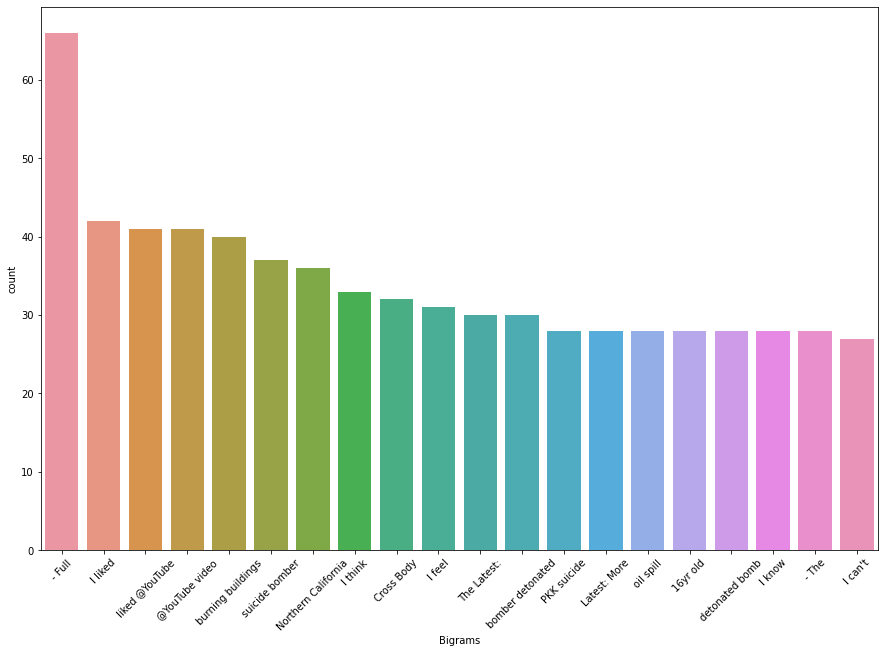

In [23]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = bigram_df['Bigrams'].head(20), y = bigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

**Trigram Analysis**

In [24]:
n = 3
trigram_df = generate_ngram_df(n, tweets_text)
trigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
trigram_df.head(10)

,Trigrams,count
0,I liked @YouTube,41
1,liked @YouTube video,41
2,suicide bomber detonated,30
3,The Latest: More,28
4,bomber detonated bomb,28
5,PKK suicide bomber,28
6,- Full reÛ_,27
7,old PKK suicide,27
8,16yr old PKK,27
9,affected fatal outbreak,26


[Text(0, 0, 'I liked @YouTube'),
 Text(0, 0, 'liked @YouTube video'),
 Text(0, 0, 'suicide bomber detonated'),
 Text(0, 0, 'The Latest: More'),
 Text(0, 0, 'bomber detonated bomb'),
 Text(0, 0, 'PKK suicide bomber'),
 Text(0, 0, '- Full re\x89Û_'),
 Text(0, 0, 'old PKK suicide'),
 Text(0, 0, '16yr old PKK'),
 Text(0, 0, 'affected fatal outbreak'),
 Text(0, 0, 'families affected fatal'),
 Text(0, 0, '40 families affected'),
 Text(0, 0, 'More 40 families'),
 Text(0, 0, '- Full read'),
 Text(0, 0, 'sue Legionnaires: More'),
 Text(0, 0, 'Legionnaires: More 40'),
 Text(0, 0, 'Families sue Legionnaires:'),
 Text(0, 0, 'In Under A'),
 Text(0, 0, 'Sandstorm In Under'),
 Text(0, 0, 'Up By A')]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


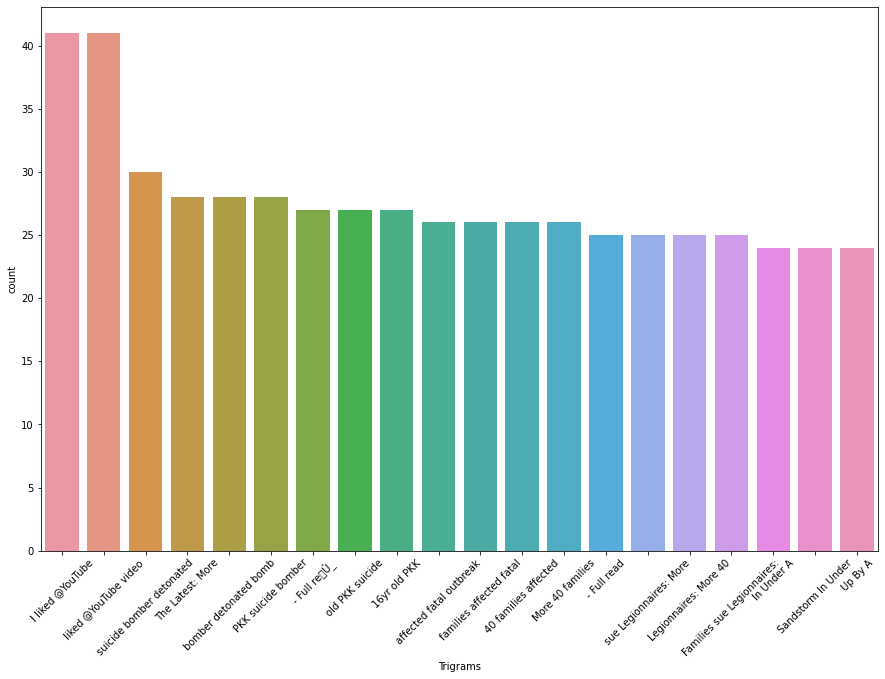

In [25]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = trigram_df['Trigrams'].head(20), y = trigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

N-Gram Analyses for Real Disaster Tweets (target = 1)

In [26]:
real_df = df[df['target'] == 1]
real_tweets = real_df['text'].values.tolist()
real_df.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


**Bigram Analysis**

In [27]:
n = 2
real_bigram_df = generate_ngram_df(n, real_tweets)
real_bigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
real_bigram_df.head(10)

,Bigrams,count
0,suicide bomber,37
1,Northern California,36
2,The Latest:,30
3,bomber detonated,30
4,Latest: More,28
5,detonated bomb,28
6,PKK suicide,28
7,oil spill,28
8,16yr old,28
9,old PKK,27


[Text(0, 0, 'suicide bomber'),
 Text(0, 0, 'Northern California'),
 Text(0, 0, 'The Latest:'),
 Text(0, 0, 'bomber detonated'),
 Text(0, 0, 'Latest: More'),
 Text(0, 0, 'detonated bomb'),
 Text(0, 0, 'PKK suicide'),
 Text(0, 0, 'oil spill'),
 Text(0, 0, '16yr old'),
 Text(0, 0, 'old PKK'),
 Text(0, 0, 'Families sue'),
 Text(0, 0, 'affected fatal'),
 Text(0, 0, 'families affected'),
 Text(0, 0, '40 families'),
 Text(0, 0, 'More 40'),
 Text(0, 0, 'fatal outbreak'),
 Text(0, 0, 'suicide bombing'),
 Text(0, 0, 'sue Legionnaires:'),
 Text(0, 0, 'Legionnaires: More'),
 Text(0, 0, 'Watch This')]

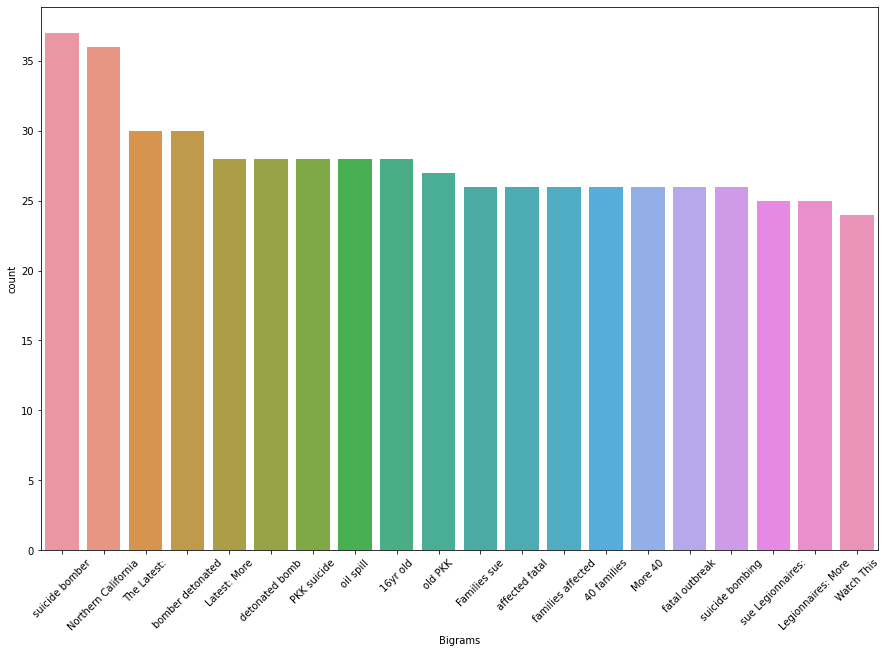

In [28]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = real_bigram_df['Bigrams'].head(20), y = real_bigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

**Trigram Analysis** 

In [29]:
n = 3
real_trigram_df = generate_ngram_df(n, real_tweets)
real_trigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
real_trigram_df.head(10)

,Trigrams,count
0,suicide bomber detonated,30
1,The Latest: More,28
2,PKK suicide bomber,28
3,bomber detonated bomb,28
4,16yr old PKK,27
5,old PKK suicide,27
6,affected fatal outbreak,26
7,More 40 families,26
8,40 families affected,26
9,families affected fatal,26


[Text(0, 0, 'suicide bomber detonated'),
 Text(0, 0, 'The Latest: More'),
 Text(0, 0, 'PKK suicide bomber'),
 Text(0, 0, 'bomber detonated bomb'),
 Text(0, 0, '16yr old PKK'),
 Text(0, 0, 'old PKK suicide'),
 Text(0, 0, 'affected fatal outbreak'),
 Text(0, 0, 'More 40 families'),
 Text(0, 0, '40 families affected'),
 Text(0, 0, 'families affected fatal'),
 Text(0, 0, 'Families sue Legionnaires:'),
 Text(0, 0, 'sue Legionnaires: More'),
 Text(0, 0, 'Legionnaires: More 40'),
 Text(0, 0, 'Get Swallowed Up'),
 Text(0, 0, 'Sandstorm In Under'),
 Text(0, 0, 'Airport Get Swallowed'),
 Text(0, 0, 'A Sandstorm In'),
 Text(0, 0, 'By A Sandstorm'),
 Text(0, 0, 'Under A Minute'),
 Text(0, 0, 'Watch This Airport')]

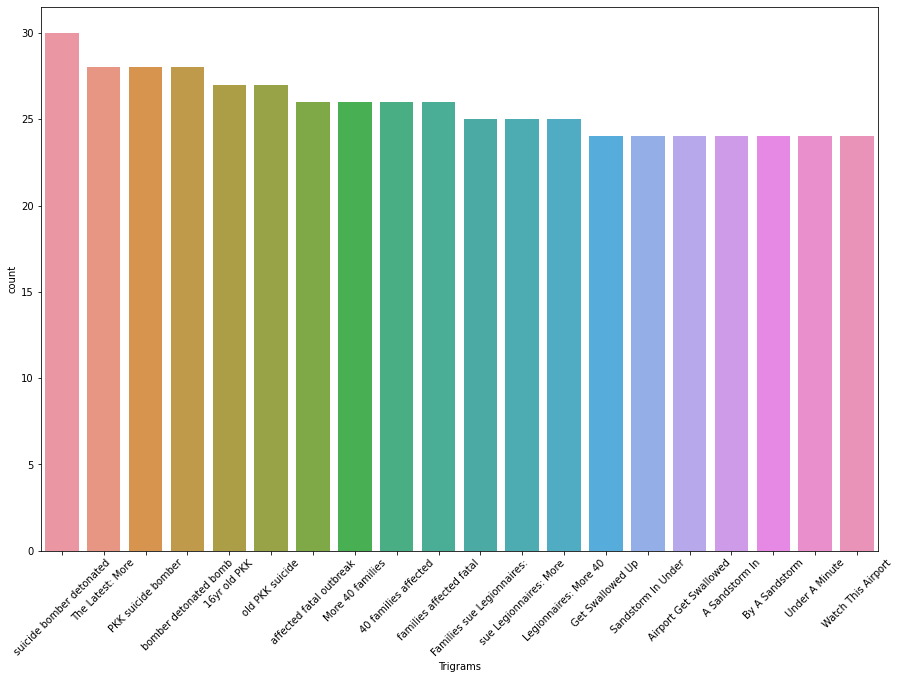

In [30]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = real_trigram_df['Trigrams'].head(20), y = real_trigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

N-Gram Analyses for Fake Disaster Tweets (target = 0)

In [31]:
fake_df = df[df['target'] == 0]
fake_tweets = fake_df['text'].values.tolist()
fake_df.head()

,keyword,location,text,target
15,NaN,NaN,What's up man?,0
16,NaN,NaN,I love fruits,0
17,NaN,NaN,Summer is lovely,0
18,NaN,NaN,My car is so fast,0
19,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


**Bigram Analysis**

In [32]:
n = 2
fake_bigram_df = generate_ngram_df(n, fake_tweets)
fake_bigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
fake_bigram_df.head(10)

,Bigrams,count
0,- Full,60
1,I liked,35
2,@YouTube video,34
3,liked @YouTube,34
4,Cross Body,31
5,I feel,25
6,I think,25
7,Full reÛ_,25
8,Full read,22
9,I can't,22


[Text(0, 0, '- Full'),
 Text(0, 0, 'I liked'),
 Text(0, 0, '@YouTube video'),
 Text(0, 0, 'liked @YouTube'),
 Text(0, 0, 'Cross Body'),
 Text(0, 0, 'I feel'),
 Text(0, 0, 'I think'),
 Text(0, 0, 'Full re\x89Û_'),
 Text(0, 0, 'Full read'),
 Text(0, 0, "I can't"),
 Text(0, 0, 'I get'),
 Text(0, 0, 'content policy'),
 Text(0, 0, '.: .:'),
 Text(0, 0, 'I want'),
 Text(0, 0, 'I know'),
 Text(0, 0, 'feel like'),
 Text(0, 0, 'Will Now'),
 Text(0, 0, 'Now Quarantine'),
 Text(0, 0, 'I love'),
 Text(0, 0, 'Fan Army')]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


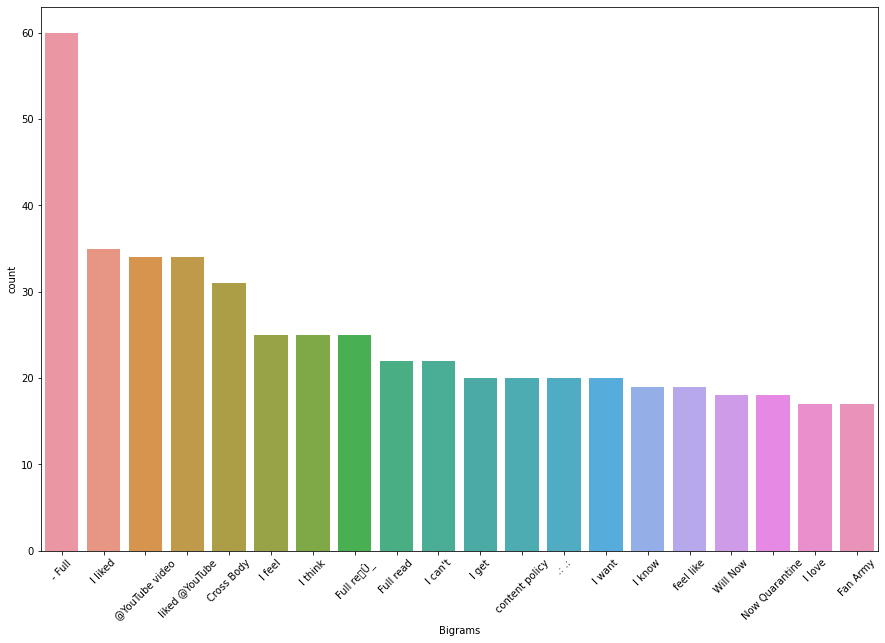

In [33]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = fake_bigram_df['Bigrams'].head(20), y = fake_bigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

**Trigram Analysis**

In [34]:
n = 3
fake_trigram_df = generate_ngram_df(n, fake_tweets)
fake_trigram_df.sort_values(by = 'count', ascending = False, inplace = True, ignore_index = True)
fake_trigram_df.head(10)

,Trigrams,count
0,I liked @YouTube,34
1,liked @YouTube video,34
2,- Full reÛ_,25
3,- Full read,22
4,.: .: .:,19
5,Will Now Quarantine,18
6,Reddit Will Now,16
7,new content policy,16
8,Reddit's new content,16
9,Now Quarantine Offensive,15


[Text(0, 0, 'I liked @YouTube'),
 Text(0, 0, 'liked @YouTube video'),
 Text(0, 0, '- Full re\x89Û_'),
 Text(0, 0, '- Full read'),
 Text(0, 0, '.: .: .:'),
 Text(0, 0, 'Will Now Quarantine'),
 Text(0, 0, 'Reddit Will Now'),
 Text(0, 0, 'new content policy'),
 Text(0, 0, "Reddit's new content"),
 Text(0, 0, 'Now Quarantine Offensive'),
 Text(0, 0, 'Full read eBay'),
 Text(0, 0, 'subreddits banned quarantined'),
 Text(0, 0, 'horrible subreddits banned'),
 Text(0, 0, 'Ignition Knock (Detonation)'),
 Text(0, 0, 'policy goes effect'),
 Text(0, 0, 'many horrible subreddits'),
 Text(0, 0, 'effect many horrible'),
 Text(0, 0, 'goes effect many'),
 Text(0, 0, 'content policy goes'),
 Text(0, 0, 'Cross Body Bag')]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


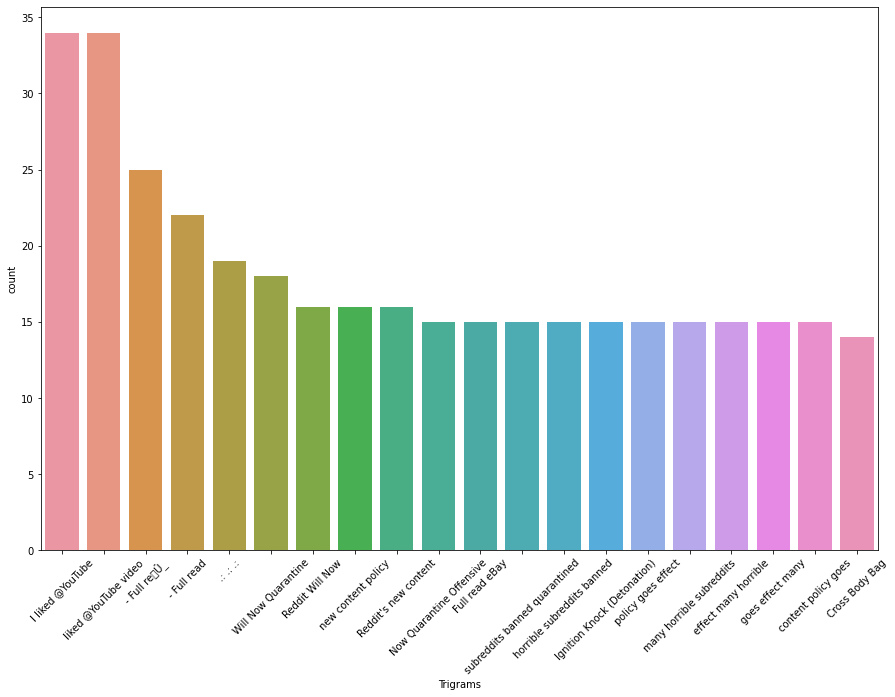

In [35]:
fig = plt.figure(figsize = (15, 10))
chart = sns.barplot(x = fake_trigram_df['Trigrams'].head(20), y = fake_trigram_df['count'].head(20))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

### Feature Engineering

#### Phase 1: Feature Engineering to generate Count Based and Demographical Features

In this method, we perform Feature Engineering on the questions. Some of the methods used for the same are :
1. Finding Length (number of characters including whitespaces) for each tweet.
2. Number of Capital Letters.
3. Ratio of the Number of Capital Letters to the Length of the tweet.
4. Number of Question (?) Marks
4. Number of Exclamation (!) Marks
5. Number of Other Punctuation marks
6. Number of Symbols
7. Number of Words
8. Number of Unique Words
9. Total Number of Words vs the Number of Unique Words
10. Mean Length of words per question. 

Other Unorthodox Methods :
1. Counting the Number of Smilies (for eg. ':-)')
2. Counting the Number of Sad Faces (for eg. ':-<')
3. Checking if a word in a title is a title or not.
4. Counting number of hashtags (#)
5. Counting number of mentions (@)

In [36]:
# copy data to another dataframe
train_df = df.copy()

# drop 'keyword' and 'location' columns
train_df.drop(['location', 'keyword'], axis = 1, inplace = True)

# extract 'target' column separately from training data
y = train_df.drop(['text'], axis = 1).values.tolist()
y = np.array(sum(y, []))

y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

**Note : Pandas passes DataFrame to function via Call by Reference instead of Call By Value so, we must perform feature generation directly without using function**

In [0]:
# Generate demographic and count based features

# Finding Length of each tweet
train_df['length'] = train_df['text'].apply(lambda x: len(x))

# Analyzing Capital Letters in each tweet
train_df['capitals'] = train_df['text'].apply(lambda tweet: sum(1 for c in tweet if c.isupper()))
train_df['caps_vs_length'] = train_df['capitals'] / train_df['length']

# Exploring number of words and their uniqueness in each tweet as well as mean length of all words in a tweet
train_df['num_words'] = train_df['text'].apply(lambda tweet: len(word_tokenize(tweet)))
train_df['num_unique_words'] = train_df['text'].apply(lambda tweet: len(set(w for w in tweet.split())))
train_df['words_vs_unique'] = train_df['num_unique_words'] / train_df['num_words']
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Generating features from punctuation
train_df['num_exclamation_marks'] = train_df['text'].apply(lambda tweet: tweet.count('!'))
train_df['num_question_marks'] = train_df['text'].apply(lambda tweet: tweet.count('?'))
train_df['num_punctuation'] = train_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in '.,;:'))
train_df['num_symbols'] = train_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in '*&$%'))
train_df['punct_percent']= train_df['num_punctuation'] * 100 / train_df['num_words']

# Checking the presence of emojis in each tweet
train_df['num_smilies'] = train_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in (':-)', ':)', ';-)', ';)')))
train_df['num_sad'] = train_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in (':-<', ':()', ';-()', ';(')))

# Checking if a particular word is a title within a tweet
train_df["count_words_title"] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Function to count the number of hashtags and mentions in each tweet
def count_symbol(x, symbol):
    pattern = r'{}'.format(symbol + '(\w+)')
    count = 0
    for match in re.finditer(pattern, x):
        count += 1
    return count

# Count the number of hashtags and mentions in each tweet
train_df['num_hashtags'] = train_df['text'].apply(count_symbol, args = ('#',))
train_df['num_mentions'] = train_df['text'].apply(count_symbol, args = ('@',))

In [38]:
train_df.head()

,text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,mean_word_len,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,punct_percent,num_smilies,num_sad,count_words_title,num_hashtags,num_mentions
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,10,0.144928,14,13,0.928571,4.384615,0,0,0,0,0.000000,0,0,5,1,0
1,Forest fire near La Ronge Sask. Canada,1,38,5,0.131579,8,7,0.875000,4.571429,0,0,1,0,12.500000,0,0,5,0,0
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,133,2,0.015038,24,20,0.833333,5.090909,0,0,1,0,4.166667,0,0,2,0,0
3,"13,000 people receive #wildfires evacuation orders in California",1,65,1,0.015385,9,8,0.888889,7.125000,0,0,1,0,11.111111,0,0,1,1,0
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,3,0.034091,18,15,0.833333,4.500000,0,0,0,0,0.000000,0,0,3,2,0


In [39]:
train_df.shape

(7613, 19)

#### Phase 2: Feature Engineering using Part of Speech (POS) Tagging

In [0]:
# function to target part of speech
def tag_part_of_speech(text):
    text_splitted =  text.split(' ')
    text_splitted = [''.join(c for c in s if c not in string.punctuation) for s in text_splitted]
    text_splitted = [s for s in text_splitted if s]
    pos_list = pos_tag(text_splitted)
    noun_count = len([w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')])
    return[noun_count, adjective_count, verb_count]

In [0]:
train_df['nouns'], train_df['adjectives'], train_df['verbs'] = zip(*train_df['text'].apply(lambda tweet: tag_part_of_speech(tweet)))

### Nouns

In [0]:
train_df['nouns_vs_length'] = train_df['nouns'] / train_df['length']
train_df['nouns_vs_words'] = train_df['nouns'] / train_df['num_words']

### Adjectives

In [0]:
train_df['adjectives_vs_length'] = train_df['adjectives'] / train_df['length']
train_df['adjectives_vs_words'] = train_df['adjectives'] / train_df['num_words']

### Verbs

In [0]:
train_df['verbs_vs_length'] = train_df['verbs'] / train_df['length']
train_df['verbs_vs_words'] = train_df['verbs'] / train_df['num_words']

In [45]:
train_df.head()

,text,target,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,mean_word_len,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,punct_percent,num_smilies,num_sad,count_words_title,num_hashtags,num_mentions,nouns,adjectives,verbs,nouns_vs_length,nouns_vs_words,adjectives_vs_length,adjectives_vs_words,verbs_vs_length,verbs_vs_words
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,10,0.144928,14,13,0.928571,4.384615,0,0,0,0,0.000000,0,0,5,1,0,6,0,1,0.086957,0.428571,0.000000,0.000000,0.014493,0.071429
1,Forest fire near La Ronge Sask. Canada,1,38,5,0.131579,8,7,0.875000,4.571429,0,0,1,0,12.500000,0,0,5,0,0,6,0,0,0.157895,0.750000,0.000000,0.000000,0.000000,0.000000
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,133,2,0.015038,24,20,0.833333,5.090909,0,0,1,0,4.166667,0,0,2,0,0,8,1,7,0.060150,0.333333,0.007519,0.041667,0.052632,0.291667
3,"13,000 people receive #wildfires evacuation orders in California",1,65,1,0.015385,9,8,0.888889,7.125000,0,0,1,0,11.111111,0,0,1,1,0,5,1,0,0.076923,0.555556,0.015385,0.111111,0.000000,0.000000
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,3,0.034091,18,15,0.833333,4.500000,0,0,0,0,0.000000,0,0,3,2,0,6,0,3,0.068182,0.333333,0.000000,0.000000,0.034091,0.166667


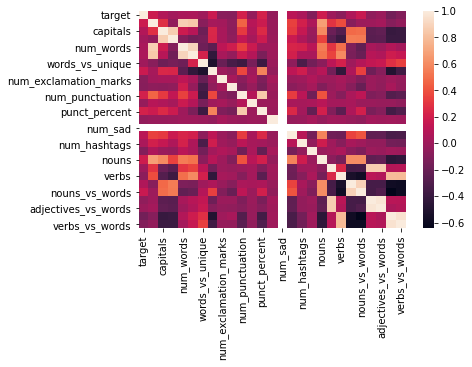

In [46]:
sns.heatmap(train_df.drop(['text'], axis = 1).corr())

In [0]:
# drop num_sad column as it is throughout 0
train_df.drop(['num_sad'], axis = 1, inplace = True)

In [48]:
num_cols = [x for x in train_df.columns if (train_df[x].dtype == 'int64' or train_df[x].dtype == 'float64') and x!= 'target']
num_cols

['length',
 'capitals',
 'caps_vs_length',
 'num_words',
 'num_unique_words',
 'words_vs_unique',
 'mean_word_len',
 'num_exclamation_marks',
 'num_question_marks',
 'num_punctuation',
 'num_symbols',
 'punct_percent',
 'num_smilies',
 'count_words_title',
 'num_hashtags',
 'num_mentions',
 'nouns',
 'adjectives',
 'verbs',
 'nouns_vs_length',
 'nouns_vs_words',
 'adjectives_vs_length',
 'adjectives_vs_words',
 'verbs_vs_length',
 'verbs_vs_words']

### Preprocessing for Baseline Model

In [49]:
train_df['preprocessed_text'] = np.array(train_tweet_corpus).T
X = train_df.drop(['text', 'target'], axis = 1)
X.head()

,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,mean_word_len,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,punct_percent,num_smilies,count_words_title,num_hashtags,num_mentions,nouns,adjectives,verbs,nouns_vs_length,nouns_vs_words,adjectives_vs_length,adjectives_vs_words,verbs_vs_length,verbs_vs_words,preprocessed_text
0,69,10,0.144928,14,13,0.928571,4.384615,0,0,0,0,0.000000,0,5,1,0,6,0,1,0.086957,0.428571,0.000000,0.000000,0.014493,0.071429,deed reason earthquake may allah forgive u
1,38,5,0.131579,8,7,0.875000,4.571429,0,0,1,0,12.500000,0,5,0,0,6,0,0,0.157895,0.750000,0.000000,0.000000,0.000000,0.000000,forest fire near la ronge sask canada
2,133,2,0.015038,24,20,0.833333,5.090909,0,0,1,0,4.166667,0,2,0,0,8,1,7,0.060150,0.333333,0.007519,0.041667,0.052632,0.291667,resident asked shelter place notified officer evacuation shelter place order expected
3,65,1,0.015385,9,8,0.888889,7.125000,0,0,1,0,11.111111,0,1,1,0,5,1,0,0.076923,0.555556,0.015385,0.111111,0.000000,0.000000,13 000 people receive wildfire evacuation order california
4,88,3,0.034091,18,15,0.833333,4.500000,0,0,0,0,0.000000,0,3,2,0,6,0,3,0.068182,0.333333,0.000000,0.000000,0.034091,0.166667,got sent photo ruby alaska smoke wildfire pours school


In [0]:
# generate TF-IDF model while preserving trigrams
vectorizer = TfidfVectorizer(max_features=2000, min_df=3, max_df=0.6, ngram_range = (1, 3))

In [0]:
# split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.225, stratify = y)

In [0]:
# generate separate FunctionTransformers for text and numeric data

# FunctionTransformer for Text Data
get_text_data = FunctionTransformer(lambda x: x['preprocessed_text'], validate = False)

# Functiontransformer for Numeric Data
get_numeric_data = FunctionTransformer(lambda x: x[num_cols], validate = False)

In [0]:
# generate numeric and text pipelines

# Numeric Pipeline
numeric_pipeline = Pipeline([('num_selector', get_numeric_data),
                             ('selector', SelectKBest(f_classif, k = 3)),
                             ('scaler', MinMaxScaler())])

# Text Pipeline
text_pipeline = Pipeline([('text_selector', get_text_data), 
                          ('vectorizer', vectorizer)])

In [66]:
# Generate final pipeline comprising of FeatureUnion and Classifier (Logistic Regression)
pl = Pipeline([('union', FeatureUnion(
    [('numeric', numeric_pipeline),
     ('text', text_pipeline)])),
     ('clf', LogisticRegression())])

# Train pipeline on data
pl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric',
                                                 Pipeline(memory=None,
                                                          steps=[('num_selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f904e0b50d0>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                            

In [67]:
pl.score(X_val, y_val)

0.804436660828955

In [68]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
# drop 'keyword and 'location' columns from testing data
df_test.drop(['keyword', 'location'], axis = 1, inplace = True)

In [70]:
df_test.shape

(3263, 2)

In [71]:
# extract tweets from test data into a separate DataFrame
test_df = df_test.drop(['id'], axis = 1)
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone."
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [72]:
test_tweet_corpus, test_lemmatized_word_corpus = preprocess_text(test_df['text'].values.tolist())
test_tweet_corpus[:5]

['happened terrible car crash',
 'heard earthquake different city stay safe everyone',
 'forest fire spot pond goose fleeing across street save',
 'apocalypse lighting spokane wildfire',
 'typhoon soudelor kill 28 china taiwan']

In [0]:
# Generate demographic and count based features

# Finding Length of each tweet
test_df['length'] = test_df['text'].apply(lambda x: len(x))

# Analyzing Capital Letters in each tweet
test_df['capitals'] = test_df['text'].apply(lambda tweet: sum(1 for c in tweet if c.isupper()))
test_df['caps_vs_length'] = test_df['capitals'] / test_df['length']

# Exploring number of words and their uniqueness in each tweet as well as mean length of all words in a tweet
test_df['num_words'] = test_df['text'].apply(lambda tweet: len(word_tokenize(tweet)))
test_df['num_unique_words'] = test_df['text'].apply(lambda tweet: len(set(w for w in tweet.split())))
test_df['words_vs_unique'] = test_df['num_unique_words'] / test_df['num_words']
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Generating features from punctuation
test_df['num_exclamation_marks'] = test_df['text'].apply(lambda tweet: tweet.count('!'))
test_df['num_question_marks'] = test_df['text'].apply(lambda tweet: tweet.count('?'))
test_df['num_punctuation'] = test_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in '.,;:'))
test_df['num_symbols'] = test_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in '*&$%'))
test_df['punct_percent']= test_df['num_punctuation'] * 100 / test_df['num_words']

# Checking the presence of emojis in each tweet
test_df['num_smilies'] = test_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in (':-)', ':)', ';-)', ';)')))
test_df['num_sad'] = test_df['text'].apply(lambda tweet: sum(tweet.count(w) for w in (':-<', ':()', ';-()', ';(')))

# Checking if a particular word is a title within a tweet
test_df["count_words_title"] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Function to count the number of hashtags and mentions in each tweet
def count_symbol(x, symbol):
    pattern = r'{}'.format(symbol + '(\w+)')
    count = 0
    for match in re.finditer(pattern, x):
        count += 1
    return count

# Count the number of hashtags and mentions in each tweet
test_df['num_hashtags'] = test_df['text'].apply(count_symbol, args = ('#',))
test_df['num_mentions'] = test_df['text'].apply(count_symbol, args = ('@',))

In [74]:
test_df.shape

(3263, 18)

In [0]:
test_df['nouns'], test_df['adjectives'], test_df['verbs'] = zip(*test_df['text'].apply(lambda tweet: tag_part_of_speech(tweet)))

### Nouns

In [0]:
test_df['nouns_vs_length'] = test_df['nouns'] / test_df['length']
test_df['nouns_vs_words'] = test_df['nouns'] / test_df['num_words']

### Adjectives

In [0]:
test_df['adjectives_vs_length'] = test_df['adjectives'] / test_df['length']
test_df['adjectives_vs_words'] = test_df['adjectives'] / test_df['num_words']

### Verbs

In [0]:
test_df['verbs_vs_length'] = test_df['verbs'] / test_df['length']
test_df['verbs_vs_words'] = test_df['verbs'] / test_df['num_words']

In [79]:
test_df.head()

,text,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,mean_word_len,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,punct_percent,num_smilies,num_sad,count_words_title,num_hashtags,num_mentions,nouns,adjectives,verbs,nouns_vs_length,nouns_vs_words,adjectives_vs_length,adjectives_vs_words,verbs_vs_length,verbs_vs_words
0,Just happened a terrible car crash,34,1,0.029412,6,6,1.000000,4.833333,0,0,0,0,0.000000,0,0,1,0,0,2,1,1,0.058824,0.333333,0.029412,0.166667,0.029412,0.166667
1,"Heard about #earthquake is different cities, stay safe everyone.",64,1,0.015625,12,9,0.750000,6.222222,0,0,2,0,16.666667,0,0,1,1,0,4,2,2,0.062500,0.333333,0.031250,0.166667,0.031250,0.166667
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,1,0.010417,22,19,0.863636,4.105263,0,0,2,0,9.090909,0,0,1,0,0,5,1,5,0.052083,0.227273,0.010417,0.045455,0.052083,0.227273
3,Apocalypse lighting. #Spokane #wildfires,40,2,0.050000,7,4,0.571429,9.250000,0,0,1,0,14.285714,0,0,2,2,0,3,0,1,0.075000,0.428571,0.000000,0.000000,0.025000,0.142857
4,Typhoon Soudelor kills 28 in China and Taiwan,45,4,0.088889,8,8,1.000000,4.750000,0,0,0,0,0.000000,0,0,4,0,0,4,0,1,0.088889,0.500000,0.000000,0.000000,0.022222,0.125000


In [0]:
# drop num_sad column as it is throughout 0
test_df.drop(['num_sad'], axis = 1, inplace = True)

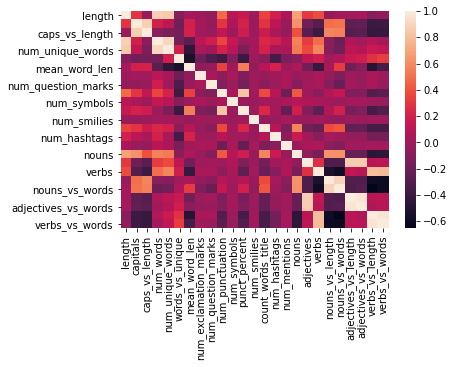

In [81]:
sns.heatmap(test_df.drop(['text'], axis = 1).corr())

In [82]:
test_num_cols = [x for x in test_df.columns if test_df[x].dtype == 'int64' or test_df[x].dtype == 'float64']
test_num_cols

['length',
 'capitals',
 'caps_vs_length',
 'num_words',
 'num_unique_words',
 'words_vs_unique',
 'mean_word_len',
 'num_exclamation_marks',
 'num_question_marks',
 'num_punctuation',
 'num_symbols',
 'punct_percent',
 'num_smilies',
 'count_words_title',
 'num_hashtags',
 'num_mentions',
 'nouns',
 'adjectives',
 'verbs',
 'nouns_vs_length',
 'nouns_vs_words',
 'adjectives_vs_length',
 'adjectives_vs_words',
 'verbs_vs_length',
 'verbs_vs_words']

In [83]:
test_df['preprocessed_text'] = np.array(test_tweet_corpus).T
X_test = test_df.drop(['text'], axis = 1)
X_test.head()

,length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,mean_word_len,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,punct_percent,num_smilies,count_words_title,num_hashtags,num_mentions,nouns,adjectives,verbs,nouns_vs_length,nouns_vs_words,adjectives_vs_length,adjectives_vs_words,verbs_vs_length,verbs_vs_words,preprocessed_text
0,34,1,0.029412,6,6,1.000000,4.833333,0,0,0,0,0.000000,0,1,0,0,2,1,1,0.058824,0.333333,0.029412,0.166667,0.029412,0.166667,happened terrible car crash
1,64,1,0.015625,12,9,0.750000,6.222222,0,0,2,0,16.666667,0,1,1,0,4,2,2,0.062500,0.333333,0.031250,0.166667,0.031250,0.166667,heard earthquake different city stay safe everyone
2,96,1,0.010417,22,19,0.863636,4.105263,0,0,2,0,9.090909,0,1,0,0,5,1,5,0.052083,0.227273,0.010417,0.045455,0.052083,0.227273,forest fire spot pond goose fleeing across street save
3,40,2,0.050000,7,4,0.571429,9.250000,0,0,1,0,14.285714,0,2,2,0,3,0,1,0.075000,0.428571,0.000000,0.000000,0.025000,0.142857,apocalypse lighting spokane wildfire
4,45,4,0.088889,8,8,1.000000,4.750000,0,0,0,0,0.000000,0,4,0,0,4,0,1,0.088889,0.500000,0.000000,0.000000,0.022222,0.125000,typhoon soudelor kill 28 china taiwan


In [0]:
y_test = pl.predict(X_test)

In [0]:
sol_df = pd.DataFrame()
sol_df['id'] = df_test.loc[:, 'id']
sol_df['target'] = y_test.T
sol_df.to_csv('submission.csv', index = False)